<a href="https://colab.research.google.com/github/Taimaaaa/Chicago-Crime-Data/blob/main/Chicago_Crime_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chicago Crime Data
* Author: Taima Nasser

##Imports & Loading

In [37]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import os
import statsmodels.tsa.api as tsa

In [12]:
zip_path = "/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/06-AdvancedML/Week22/Data/Chicago_Crime_2001-2022.zip"
os.path.exists(zip_path)

True

In [13]:
extract_dir = "/content/chicago_crime"
os.makedirs(extract_dir, exist_ok=True)

In [14]:
!unzip -q "$zip_path" -d "$extract_dir"

replace /content/chicago_crime/Data/Chicago-Crime_2001.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/chicago_crime/Data/Chicago-Crime_2002.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [15]:
data_dir = os.path.join(extract_dir, "Data")
os.listdir(data_dir)

['Chicago-Crime_2020.csv',
 'Chicago-Crime_2012.csv',
 'Chicago-Crime_2014.csv',
 'Chicago-Crime_2019.csv',
 'Chicago-Crime_2008.csv',
 'Chicago-Crime_2021.csv',
 'Chicago-Crime_2005.csv',
 'Chicago-Crime_2017.csv',
 'Chicago-Crime_2007.csv',
 'Chicago-Crime_2018.csv',
 'Chicago-Crime_2013.csv',
 'README.txt',
 'Chicago-Crime_2015.csv',
 'Chicago-Crime_2001.csv',
 'Chicago-Crime_2004.csv',
 'Chicago-Crime_2010.csv',
 'Chicago-Crime_2022.csv',
 'Chicago-Crime_2011.csv',
 'Chicago-Crime_2002.csv',
 'Chicago-Crime_2003.csv',
 'Chicago-Crime_2016.csv',
 'Chicago-Crime_2006.csv',
 'Chicago-Crime_2009.csv']

In [17]:
dfs = []

for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        path = os.path.join(data_dir, file)
        temp_df = pd.read_csv(path, low_memory=False)
        dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

In [19]:
df.shape

(7624075, 12)

In [20]:
df.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,11938145,01/01/2020 01:00:00 AM,ASSAULT,SIMPLE,BAR OR TAVERN,False,True,2432,24.0,40.0,41.998469,-87.670737
1,11943521,01/01/2020 01:00:00 AM,THEFT,$500 AND UNDER,STREET,False,False,1934,19.0,44.0,41.935958,-87.636774
2,11938710,01/01/2020 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,1933,19.0,32.0,41.934361,-87.659677
3,11938671,01/01/2020 01:00:00 PM,ASSAULT,AGGRAVATED: OTHER DANG WEAPON,RESIDENCE,True,True,1711,17.0,39.0,41.992882,-87.726396
4,11938632,01/01/2020 01:00:00 PM,ROBBERY,ARMED - HANDGUN,STREET,True,False,1512,15.0,29.0,41.884811,-87.771944


##Preparing Datetime Index

In [21]:
# ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# drop rows with invalid dates
df = df.dropna(subset=['Date'])

# set datetime index and sort
df = df.set_index('Date').sort_index()

# confirm structure
df.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01,1541842,DECEPTIVE PRACTICE,EMBEZZLEMENT,AIRPORT/AIRCRAFT,True,False,1651,16.0,NaN,NaN,NaN
2001-01-01,4768442,OFFENSE INVOLVING CHILDREN,SEX ASSLT OF CHILD BY FAM MBR,RESIDENCE,False,False,2124,2.0,4.0,41.807275,-87.593707
2001-01-01,2280620,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,915,9.0,20.0,41.806311,-87.674782
2001-01-01,9755214,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,False,1022,10.0,24.0,NaN,NaN
2001-01-01,1310854,CRIMINAL DAMAGE,TO VEHICLE,OTHER,False,False,2411,24.0,NaN,42.008635,-87.686869


##Create a Daily Crime Counts Dataset (Resampled Version)

In [22]:
# resample to daily frequency
# size() counts number of crimes per day
crime_daily = df.resample('D').size()

# convert to DataFrame for easier use
crime_daily = crime_daily.to_frame(name='total_crimes')

crime_daily.head()

,total_crimes
Date,
2001-01-01,1825
2001-01-02,1143
2001-01-03,1151
2001-01-04,1166
2001-01-05,1267


##Topic 1 — Comparing Police Districts (2022)
* Which district had the most crimes in 2022?
* Which had the least?

In [23]:
# filter to year 2022 only
df_2022 = df.loc['2022']

In [24]:
# count crimes by district
district_counts_2022 = df_2022['District'].value_counts()

district_counts_2022

,count
District,
8.0,14805
6.0,14694
12.0,14341
4.0,13931
11.0,13457
1.0,13044
18.0,12429
19.0,12243
25.0,11951


In [25]:
# district with most crimes
most_crime_district = district_counts_2022.idxmax()
most_crime_count = district_counts_2022.max()

# district with least crimes
least_crime_district = district_counts_2022.idxmin()
least_crime_count = district_counts_2022.min()

most_crime_district, most_crime_count, least_crime_district, least_crime_count

(np.float64(8.0), 14805, np.float64(31.0), 15)

###**Topic 1: Comparing Police Districts (2022)**

**Objective**:
Identify which police districts experienced the highest and lowest number of crimes in Chicago during 2022.

**Findings**:

* **District with the most crimes in 2022**

  * **District 8**

  * Total reported crimes: **14,805**

* **District with the least crimes in 2022**

  * **District 31**

  * Total reported crimes: **15**

**Key Observations:**

* Crime distribution across districts is highly uneven.

* District 8 experiences significantly higher crime volume compared to other districts.

* District 31 reports extremely low crime activity, which may be due to:

  * Smaller geographic area

  * Lower population density

  * Administrative or reporting differences

**Conclusion:**

* Crime in Chicago during 2022 was concentrated in specific districts rather than evenly spread.

* District-level analysis is essential for targeted policing and resource allocation.

* High-crime districts may benefit from increased patrols and preventative strategies, while low-crime districts require continued monitoring rather than intensive intervention.

##Topic 2: Comparing AM vs PM Rush Hour
* Are crimes more common during AM rush hour or PM rush hour?
* What are the top 5 most common crimes during AM rush
hour?
* What are the top 5 most common crimes during PM rush hour?
* Are Motor Vehicle Thefts more common during AM rush hour
or PM Rush Hour?

In [26]:
# extract hour from datetime index
df['hour'] = df.index.hour

# define AM and PM rush hour windows
# AM rush hour: 7 AM – 10 AM
# PM rush hour: 4 PM – 7 PM (16–19)
df['rush_period'] = 'Other'

df.loc[(df['hour'] >= 7) & (df['hour'] <= 10), 'rush_period'] = 'AM Rush'
df.loc[(df['hour'] >= 16) & (df['hour'] <= 19), 'rush_period'] = 'PM Rush'

In [29]:
# keep only AM and PM rush hour crimes
rush_df = df[df['rush_period'].isin(['AM Rush', 'PM Rush'])].copy()

In [30]:
# count total crimes during each rush period
rush_counts = rush_df['rush_period'].value_counts()

rush_counts

,count
rush_period,
PM Rush,1622798
AM Rush,1084508


In [31]:
# filter AM rush hour crimes
am_rush = rush_df[rush_df['rush_period'] == 'AM Rush']

# top 5 most common crime types in AM rush hour
top5_am = am_rush['Primary Type'].value_counts().head(5)

top5_am

,count
Primary Type,
THEFT,257956
BATTERY,156129
CRIMINAL DAMAGE,107639
BURGLARY,95784
OTHER OFFENSE,88851


In [32]:
# filter PM rush hour crimes
pm_rush = rush_df[rush_df['rush_period'] == 'PM Rush']

# top 5 most common crime types in PM rush hour
top5_pm = pm_rush['Primary Type'].value_counts().head(5)

top5_pm

,count
Primary Type,
THEFT,374543
BATTERY,284655
CRIMINAL DAMAGE,181329
NARCOTICS,164521
ASSAULT,116269


In [33]:
# filter motor vehicle thefts only
vehicle_theft = rush_df[rush_df['Primary Type'] == 'MOTOR VEHICLE THEFT']

# count by rush period
vehicle_theft_counts = vehicle_theft['rush_period'].value_counts()

vehicle_theft_counts

,count
rush_period,
PM Rush,73497
AM Rush,53365


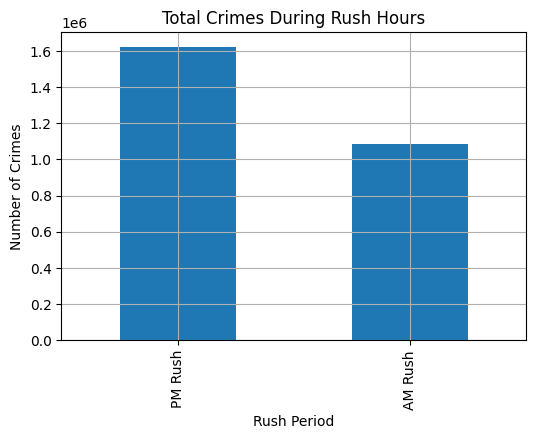

In [36]:
ax = rush_counts.plot(
    kind='bar',
    figsize=(6,4),
    title='Total Crimes During Rush Hours',
    ylabel='Number of Crimes',
    xlabel='Rush Period',
    grid=True
)

plt.show()

###**Topic 3: Comparing AM vs. PM Rush Hour Crime**

**Objective:**
Determine whether crimes are more common during AM or PM rush hours, identify the most frequent crime types during each period, and assess when Motor Vehicle Thefts are more prevalent.

**Rush Hour Definitions:**

* **AM Rush Hour:** 7:00 AM – 10:00 AM

* **PM Rush Hour:** 4:00 PM – 7:00 PM

**Overall Crime Volume:**

* **PM Rush Hour**

  * Total crimes: **1,622,798**

* **AM Rush Hour**

  * Total crimes: **1,084,508**

* **Conclusion:** Crimes are significantly more common during PM rush hour than AM rush hour.

**Top 5 Most Common Crimes During AM Rush Hour:**

* Theft: **257,956**

* Battery: **156,129**

* Criminal Damage: **107,639**

* Burglary: **95,784**

* Other Offense: **88,851**

**Top 5 Most Common Crimes During PM Rush Hour:**

* Theft: **374,543**

* Battery: **284,655**

* Criminal Damage: **181,329**

* Narcotics: **164,521**

* Assault: **116,269**

**Motor Vehicle Theft Comparison:**

* **PM Rush Hour**

  * Motor vehicle thefts: **73,497**

* **AM Rush Hour**

  * Motor vehicle thefts: **53,365**

* **Conclusion:** Motor vehicle thefts are more common during PM rush hour.

**Key Insights:**

* PM rush hour consistently shows higher crime volume across all analyses.

* Theft and battery dominate both AM and PM rush periods.

* Violent and drug-related crimes (assault, narcotics) appear more prominently during PM hours.

* Increased traffic, pedestrian activity, and reduced visibility in the evening may contribute to higher PM crime rates.

**Final Conclusion:**

* PM rush hour represents a higher-risk period for crime in Chicago.

* Law enforcement and public safety efforts may be more effective if focused on evening commuting hours.

* Targeted patrols during PM rush hours could help reduce theft and vehicle-related crimes.

##Topic 3 -Cycles/Seasonality of the Data

####Total Crimes Monthly Seasonaliy

/tmp/ipython-input-1520543753.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total = df.resample('M').size()


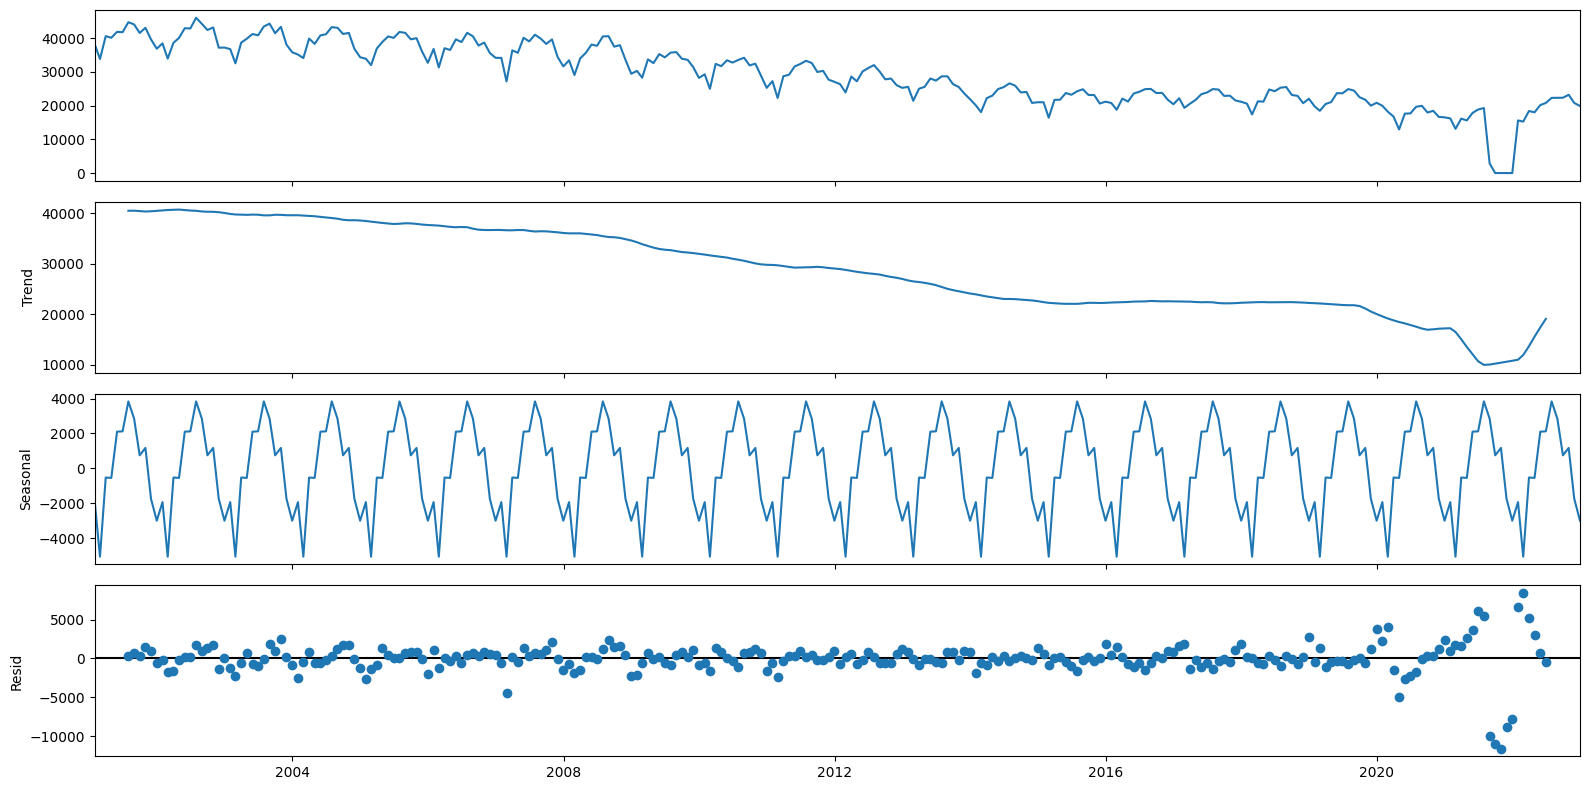

In [40]:
monthly_total = df.resample('M').size()

#seasonal decomposition (monthly → yearly seasonality)
decomp_monthly = tsa.seasonal_decompose(
    monthly_total,
    model='additive',
    period=12
)
fig = decomp_monthly.plot()
fig.set_size_inches(16, 8)
fig.tight_layout()

####Quantifying Seasonality (Cycle Length & Magnitude)

In [48]:
seasonal_component1 = decomp_monthly.seasonal

# magnitude of cycle
magnitude = seasonal_component1.max() - seasonal_component1.min()
magnitude

8897.74404761905

In [49]:
# identify peak and trough dates
seasonal_component1.idxmax(), seasonal_component1.idxmin()

(Timestamp('2001-07-31 00:00:00'), Timestamp('2001-02-28 00:00:00'))

In [50]:
# estimate cycle length
cycle_length = seasonal_component1.idxmax() - seasonal_component1.idxmin()
cycle_length

Timedelta('153 days 00:00:00')

####Theft Monthly Seasonality

In [41]:
crime_type = 'THEFT'
crime_df = df[df['Primary Type'] == crime_type]

/tmp/ipython-input-947936078.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_crime = crime_df.resample('M').size()


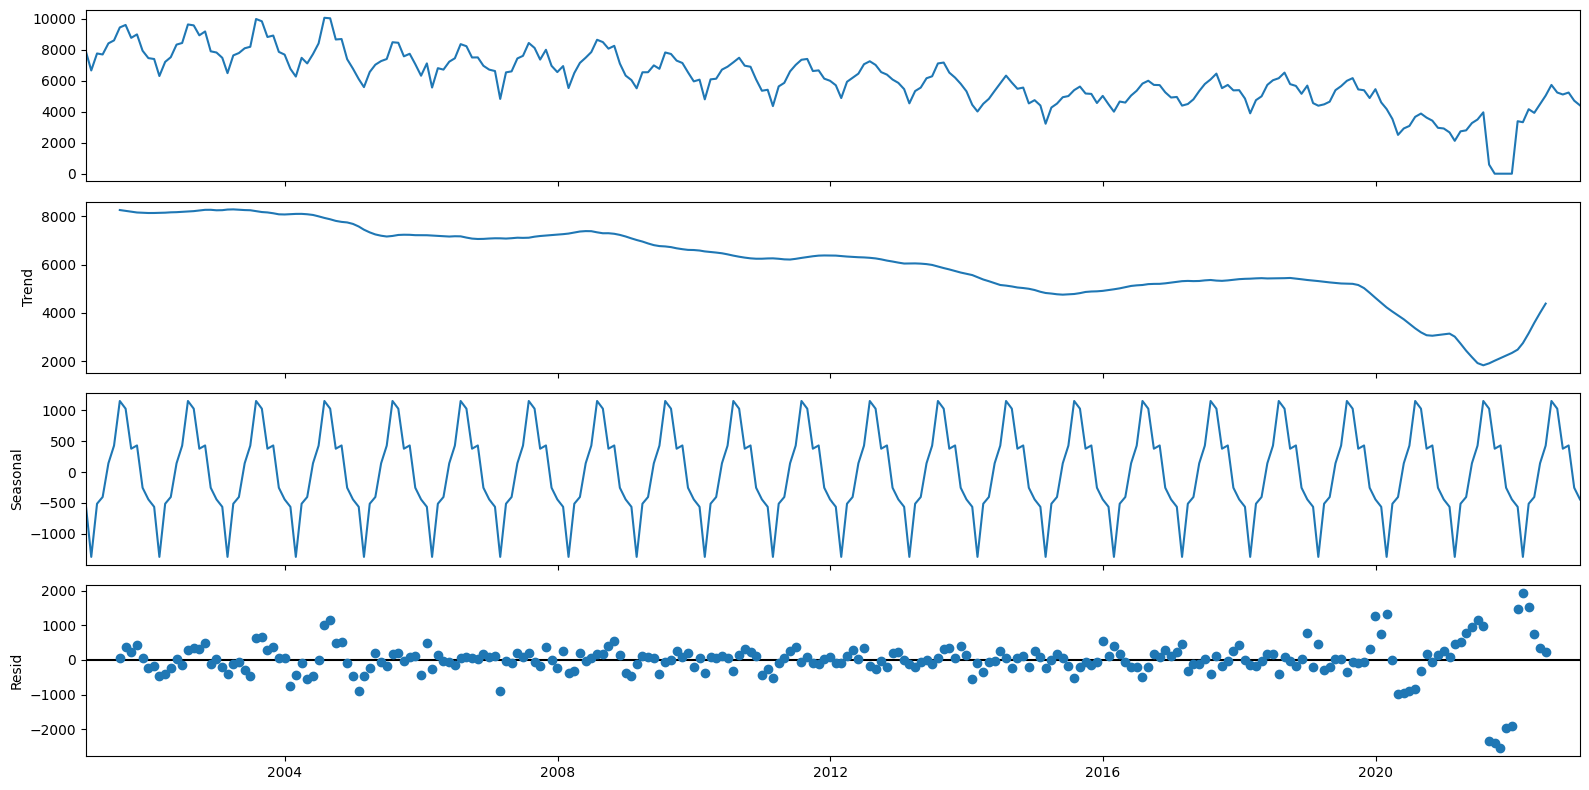

In [43]:
monthly_crime = crime_df.resample('M').size()
decomp_monthly_crime = tsa.seasonal_decompose(
    monthly_crime,
    model='additive',
    period=12
)
fig = decomp_monthly_crime.plot()
fig.set_size_inches(16, 8)
fig.tight_layout()

####Quantifying Seasonality (Cycle Length & Magnitude)

In [45]:
seasonal_component2 = decomp_monthly_crime.seasonal

# magnitude of cycle
magnitude = seasonal_component2.max() - seasonal_component2.min()
magnitude

2517.0912698412703

In [46]:
# identify peak and trough dates
seasonal_component2.idxmax(), seasonal_component2.idxmin()

(Timestamp('2001-07-31 00:00:00'), Timestamp('2001-02-28 00:00:00'))

In [47]:
# estimate cycle length
cycle_length = seasonal_component2.idxmax() - seasonal_component2.idxmin()
cycle_length

Timedelta('153 days 00:00:00')

#### Topic 3 — Seasonality Analysis (Cycles in Chicago Crime Data)

This section analyzes **seasonality (recurring cycles)** in Chicago crime data using
`statsmodels.tsa.seasonal_decompose`.  
We examined **monthly total crimes** and **monthly THEFT crimes** to identify:
- Whether seasonality exists  
- How long a cycle lasts  
- How strong the cycle is (magnitude)


1. Total Crime — Monthly Seasonality

**Data preparation**
- Resampled all crimes to **monthly frequency**
- Aggregation method: total count per month
- Decomposition model: **additive**
- Period: **12 months** (yearly seasonality)

**Observed components**
- **Trend**
  - Clear long-term downward trend in total crimes
  - Sharp dip around 2020–2021, likely reflecting COVID-era disruptions
- **Seasonal**
  - Strong, repeating yearly pattern
  - Crime counts rise and fall in a consistent annual cycle
- **Residual**
  - Mostly random noise after removing trend and seasonality
  - Larger residual spikes around major disruptions (e.g., 2020)

**Cycle length**
- Peak date: July
- Trough date: February
- Estimated half-cycle length: **~153 days**
- Full seasonal cycle: **~12 months (1 year)**

**Cycle magnitude**
- Seasonal max − seasonal min ≈ **8,897 crimes per month**
- Interpretation:
  - At peak months, total crime is nearly **9,000 incidents higher**
    than at seasonal lows

**Conclusion (Total Crime)**
- Total crime in Chicago shows **strong annual seasonality**
- Crimes peak in **summer months** and decline in **winter months**
- The seasonal effect is large and meaningful, not just random noise


2. THEFT Crimes — Monthly Seasonality

**Data preparation**
- Filtered data to `Primary Type = THEFT`
- Resampled to **monthly frequency**
- Decomposition model: **additive**
- Period: **12 months**

**Observed components**
- **Trend**
  - Long-term decline in thefts
  - Steeper drop after 2019, with partial recovery afterward
- **Seasonal**
  - Clear, repeating yearly cycle similar to total crime
  - Higher theft activity in warmer months
- **Residual**
  - Mostly centered around zero
  - Larger deviations during major city-wide disruptions

**Cycle length**
- Peak date: July
- Trough date: February
- Estimated half-cycle length: **~153 days**
- Full seasonal cycle: **~12 months (1 year)**

**Cycle magnitude**
- Seasonal max − seasonal min ≈ **2,517 thefts per month**
- Interpretation:
  - Seasonal effects account for swings of over **2,500 thefts per month**

**Conclusion (THEFT)**
- THEFT crimes exhibit **clear annual seasonality**
- Pattern closely mirrors total crime seasonality
- Seasonal effects are substantial but smaller in scale than total crime

3. Overall Takeaways

- Chicago crime data shows **strong yearly seasonality**
- **Cycle length:** approximately **1 year**
- **Peak period:** summer (around July)
- **Low period:** winter (around February)
- **Magnitude matters**
  - ~9,000 crimes/month swing for total crime
  - ~2,500 crimes/month swing for theft alone
- Seasonal decomposition successfully separates:
  - Long-term trends
  - Repeating seasonal behavior
  - Irregular residual noise

These findings suggest that **seasonal factors (weather, activity levels, mobility) play a major role**
in crime patterns and should be considered in planning, policing, and policy decisions.
